**Recovering a joint PDF from its marginal distributions**

Given the PDFs $f_X$ and $f_Y$ as well as the correlation of their random variables $\mathbb{E}[XY] = C$, we wish to calculate the joint PDF $f_{XY}$. As there exists multiple joint distributions whose marginals are given by $f_X, f_Y$ and have the correlation $\mathbb{E}[XY] = C$ we choose to select the joint PDF which maximises the entropy. This distribution is given by minimising negative entropy (equivalent to maximising entropy)

\begin{align*}
\mathcal{L} = & \iint f_{XY}(x,y) log\left( f_{XY}(x,y) \right) \, dxdy \\
              & + \alpha \left( \iint f_{XY}(x,y) dxdy - 1 \right) \\
              & + \lambda \left( \iint xy f_{XY}(x,y) dxdy - c \right) \\
              & + \int \mu_X(x) \left( \int f_{XY}(x,y) dy - f_X(x) \right) dx \\
              & + \int \mu_Y(y) \left( \int f_{XY}(x,y) dx - f_Y(y) \right) dy,
\end{align*}

where $\alpha,\lambda, \mu_X, \mu_Y$ are Lagrange multipliers which must be determined by imposing the constraints. Taking variations with respect to the Lagrange multipliers provides the four constraints we wish to impose i.e. the joint PDF sums to unity, its covariance equals $c$ and its marginals are equal to those we supply. Taking variations with respect to $f_{XY}$ provides the gradient

\begin{equation*}
\frac{\delta \mathcal{L}}{\delta f_{XY}} = \left( 1 + log(f_{XY}(x,y)) \right) + \alpha + \lambda xy + \mu_X(x) + \mu_Y(y).
\end{equation*}

As $0 \geq f_{XY} \leq 1$ because it is a probability, in the definition of entropy we must multiply by $-1$ to compensate for $log f_{XY}$ being negative i.e. $S = -\iint f_{XY}(x,y) log\left( f_{XY}(x,y) \right) \, dxdy \geq 0$.

To solve this problem we will use the sequential least sqaures quadratic programming (SLSQP) optimiser, to which we will pass the gradient as defined above and the four consraints

\begin{align*}
\frac{\delta \mathcal{L}}{\delta \alpha } &= \iint f_{XY}(x,y) dxdy - 1 = 0, \\
\frac{\delta \mathcal{L}}{\delta \lambda} &= \iint xy f_{XY}(x,y) dxdy - c  = 0, \\
\frac{\delta \mathcal{L}}{\delta \mu_X  } &= \int f_{XY}(x,y) dy - f_X(x) = 0, \\
\frac{\delta \mathcal{L}}{\delta \mu_Y  } &= \int f_{XY}(x,y) dx - f_Y(y) = 0,
\end{align*}

enabling us to determine $\alpha,\lambda, \mu_X, \mu_Y$ and hence $\frac{\delta \mathcal{L}^n}{\delta f_{XY}}$ at a given iteration $n$. The optimiser will then iteratively update the joint PDF starting from our initial guess $f^{n=0}_{XY}$ according to the rule

\begin{equation}
f^{n+1}_{XY} = f^{n}_{XY} - \epsilon \frac{\delta \mathcal{L}^n}{\delta f_{XY}},
\end{equation}

where $\epsilon^n$ is the step-size selected at each iteration by the optimiser and the $(-)$ sign follows from the fact we are minimising the negative entropy.


/tmp/ipykernel_8723/4028247537.py:26: RuntimeWarning: invalid value encountered in log
  L    = np.sum(f_XY*np.log(f_XY))*dx*dy


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.4484062104943622
       x: [ 1.548e-02  8.516e-03 ...  1.081e-02  6.981e-03]
     nit: 109
     jac: [-3.888e+00 -3.506e+00 ... -3.860e+00 -3.221e+00]
    nfev: 327
    njev: 109


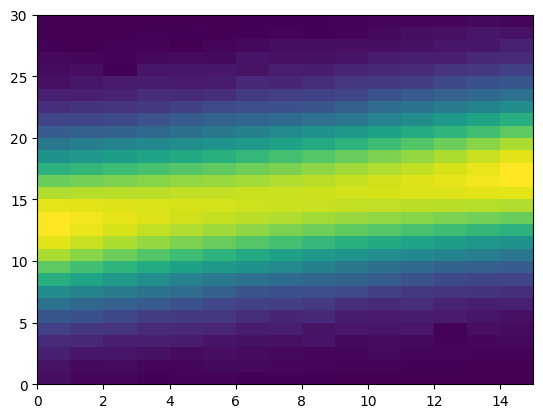

In [13]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

Nx = 30
Ny = 15

# Define an x,y grid
x, dx = np.linspace(-3, 3, num=Nx, retstep=True) 
y, dy = np.linspace(0, 1, num=Ny, retstep=True) 
X = np.kron(x, np.ones(Ny))
Y = np.kron(np.ones(Nx), y)

# Define f_X, f_Y & c
f_X = np.exp(-x**2/2)/np.sqrt(2*np.pi)
f_Y = np.ones(Ny)
c   = 0.1

# Define initial f_XY 
f_XY_0 = np.kron(f_X, f_Y)

# Define our objective function to be minimised
def obj_fun(f_XY):#, α, λ, μ_X, μ_Y): 
    
    f_XY = f_XY.reshape((Nx,Ny))
    L    = np.sum(f_XY*np.log(f_XY))*dx*dy 
    
    return L

# Define the gradient
def grad_fun(f_XY):
    
    I = np.ones(Nx*Ny)
    dL= I + np.log(f_XY)    
    
    return dL

from scipy.optimize import NonlinearConstraint as NLC

# Define the constraints
def con_density(f_XY):
    #Superfulos condition if the other two are imposed
    return np.sum(f_XY)*dx*dy - 1

def con_covariance(f_XY):
    return np.sum(X*Y*f_XY)*dx*dy - c

def con_marginal_X(f_XY):
    return (np.sum(f_XY.reshape((Nx,Ny)), axis=1)*dy) - f_X

def con_marginal_Y(f_XY):
    return (np.sum(f_XY.reshape((Nx,Ny)), axis=0)*dx) - f_Y

cons = [NLC(con_covariance,0,0), NLC(con_marginal_X,0,0)]#, NLC(con_marginal_Y,0,0)] #, NLC(con_marginal_Y,0,0)] # NLC(con_density,0,0), 


# Call the minimiser
res = minimize(fun=obj_fun, x0=f_XY_0, args = (), method='SLSQP', jac = grad_fun, constraints = cons, tol=1e-01, options = {'maxiter':200, 'disp':False} )

print(res)
f_XY = res.x.reshape((Nx,Ny))
plt.pcolormesh(f_XY)
plt.show()